# Radial diffusion

<p>Radial diffusion can be implemented in rxd using multicompartment reactions. By creating a series of shells and borders with reactions between them dependent the diffusion coefficient.</p>

In [1]:
from neuron import n, rxd
from neuron.units import nM, uM
from matplotlib import pyplot
import numpy

n.load_file("stdrun.hoc")

1.0

Create the NEURON, in this case a simply dendrite connected to a soma.

In [2]:
soma = n.Section("soma")
soma.L = soma.diam = 25
soma.nseg = 1

dend = n.Section("dend")
dend.L = 20
dend.diam = 5
dend.nseg = 101
dend.connect(soma)

dend

<p>Following the rxd Where/Who/What framework start by defining the where the diffusion takes place. Here we use 5 shells each with thickness 1μM in the dendrite and 5μM in the soma.</p>

In [3]:
# Where -- define the shells and borders
N = 5  # number of shells -- must be >= 2

# Where -- shells and border between them
shells = []
border = []
for i in range(N - 1):
    shells.append(
        rxd.Region(
            n.allsec(),
            name=f"shell{i}",
            geometry=rxd.Shell(i / N, (1.0 + i) / N),
        )
    )
    border.append(
        rxd.Region(
            n.allsec(),
            name=f"border{i}",
            geometry=rxd.FixedPerimeter(2.0 * n.PI * (1.0 + i)),
        )
    )

# the outer shell corresponds NEURON section concentration e.g. dend(0.5).cai
shells.append(
    rxd.Region(
        n.allsec(),
        nrn_region="i",
        name=f"shell{N}",
        geometry=rxd.Shell((N - 1.0) / N, 1.0),
    )
)

<p>Next we define 'Who' the calcium that is diffusing. Because multicompartment reactions are specified in moleques/μ
m2
/ms we need to scale the diffusion coefficient used in the reactions.
We start the simulation with the a high concentration (1μ
M) in the middle of the dendrite on the outer shell.<p>

In [4]:
# Who -- calcium with an inhomogeneous initial condition
Dca = 0.6  # um^2/ms

# scale factor so the flux (Dca/dr)*Ca has units molecules/um^2/ms (where dr is the thickness of the shell)
mM_to_mol_per_um = 6.0221409e23 * 1e-18

ca = rxd.Species(
    shells,
    d=Dca,
    name="ca",
    charge=2,
    initial=lambda nd: 1.0 * uM
    if 9.5 < nd.x3d - soma.L < 10.5 and nd.region == shells[-1]
    else 60 * nM,
)

<p>Finally we specify 'What' the reactions that perform the radial diffusion.</p>



In [5]:
# What -- use reactions to setup diffusion between the shells
cas = [ca[reg] for reg in shells]  # calcium on the shells

# create the multi-compartment reactions between the pairs of shells
diffusions = []
for i in range(N - 1):
    diffusions.append(
        rxd.MultiCompartmentReaction(
            cas[i],
            cas[i + 1],
            mM_to_mol_per_um * Dca,
            mM_to_mol_per_um * Dca,
            border=border[i],
        )
    )

<p>Now run the simulation and plot the results. The concentrations rapidly equilibrate between the shells, the speed is dependent on the diffusion coefficient, which could be reduced to account for tortuosity of macromolecular crowding in the cytosol. Additionally calcium buffering and uptake could be included with additional reactions and would also reduce this speed.</p>

Text(0, 0.5, 'Ca$^{+2}$ (nM)')

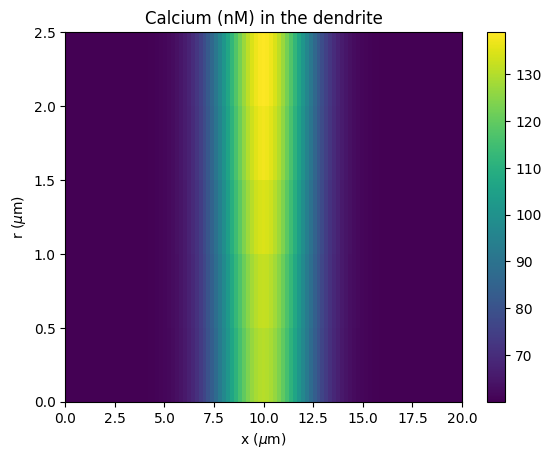

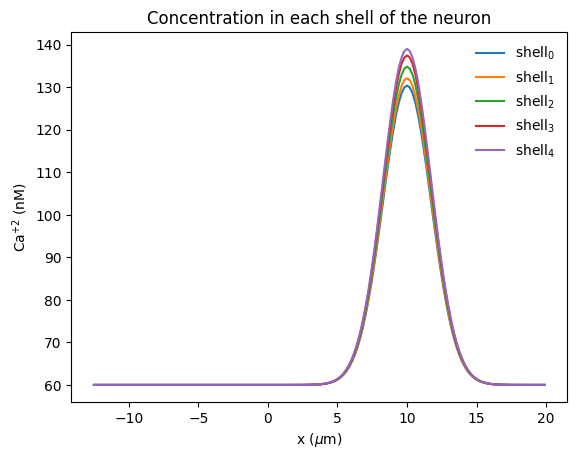

In [9]:
# run for 2.5ms and plot the results
n.finitialize(-65)
n.continuerun(2.5)

# plot the calcium concentration (in nM) in the dendrite
pyplot.figure()
pyplot.title("Calcium (nM) in the dendrite")
pyplot.imshow(
    numpy.array(ca.nodes(dend).concentration).reshape(N, dend.nseg) / nM,
    origin="lower",
    extent=(0, dend.L, 0, dend.diam / 2.0),
    aspect="auto",
)
pyplot.colorbar()
pyplot.xlabel("x ($\mu$m)")
pyplot.ylabel("r ($\mu$m)")


# plot the calcium concentration in the neuron in each of the shells
pyplot.figure()
pyplot.title("Concentration in each shell of the neuron")
for i, shell in enumerate(shells):
    pyplot.plot(
        [nd.x3d - soma.L for nd in ca.nodes(shell)],
        [nd.concentration / nM for nd in ca.nodes(shell)],
        label=f"shell$_{i}$",
    )
pyplot.legend(frameon=False)
pyplot.xlabel("x ($\mu$m)")
pyplot.ylabel("Ca$^{+2}$ (nM)")

The heatmap shows the concentration of calcium (in nM) along the length of the dendrite (x-axis) and across the radial shells (y-axis) after 2.5ms. The second plot shows the concentration in each of the shells over the whole length of the neuron (the soma connects to the dendrite at x=0).